# Modeling

In [17]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Reading in data, droping unnecessary column from export
mvp_df = pd.read_csv('./data/mvp.csv')
mvp_df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
mvp_df.head()

,subreddit,title,selftext,has_selftext
0,Fantasy,Looking for contained grimdark stories,"I love grimdark stories, but am also starting ...",1
1,Fantasy,Pariahs my new novel!,NaN,0
2,Fantasy,The Mask Falling SPOILERS,Ok can we discuss the fourth book in Samantha ...,1
3,Fantasy,GREAT MAGIC SYSTEM WITH A TWIST,[removed],1
4,Fantasy,AMAZING MAGIC SYSTEM WITH A TWIST,NaN,0


In [4]:
#Train Test Split
X = mvp_df['title']
y = mvp_df['subreddit']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

In [5]:
#Logistic Regression w/ Count Vectorizer Pipeline
cv_lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(n_jobs=5))
])
print(f'Count Vectorizer - Logistic Regression Cross Value Score: {cross_val_score(cv_lr_pipe,X_train,y_train).mean()}')

Count Vectorizer - Logistic Regression Cross Value Score: 0.8313333333333333


In [8]:
##Logistic Regression w/ TF-IDF Vectorizer Pipeline
tf_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(n_jobs=5))
])
print(f'TF-IDF Vectorizer - Logistic Regression Cross Value Score: {cross_val_score(tf_lr_pipe,X_train,y_train).mean()}')

TF-IDF Vectorizer - Logistic Regression Cross Value Score: 0.8413333333333334


In [9]:
#Naive-Bayes: Bernoulli w/ Count Vectorizer Pipeline
cv_nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', BernoulliNB())
])
print(f'Count Vectorizer - Naive-Bayes Cross Value Score: {cross_val_score(cv_nb_pipe,X_train,y_train).mean()}')

Count Vectorizer - Naive-Bayes Cross Value Score: 0.8391111111111111


In [10]:
#Naive-Bayes: Bernoulli w/ TF-IDF Vectorizer Pipeline
tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', BernoulliNB())
])
print(f'TF-IDF Vectorizer - Naive-Bayes Cross Value Score: {cross_val_score(tf_nb_pipe,X_train,y_train).mean()}')

TF-IDF Vectorizer - Naive-Bayes Cross Value Score: 0.8391111111111111


In [11]:
#Support Vector Classifer
cv_svc_pipe = Pipeline([
     ('cvec', CountVectorizer()),
    ('svc', SVC()) 
 ])
print(f'Support Vector Classifer Cross Value Score: {cross_val_score(cv_svc_pipe,X_train,y_train).mean()}')    

Support Vector Classifer Cross Value Score: 0.8128888888888888


In [12]:
#Support Vector Classifer w/ TF-IDF Vectorizer Pipeline
tf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])
print(f'Support Vector Classifer Cross Value Score: {cross_val_score(tf_svc_pipe,X_train,y_train).mean()}')

Support Vector Classifer Cross Value Score: 0.8402222222222223


In [13]:
#Best performing model is Logistic Regression w/ TF-IDF Vectorizer Pipeline so that is our MVP
mvp_pipe = tf_lr_pipe

In [20]:
#Fitting model
mvp_pipe.fit(X_train,y_train)
print(f'The Train Score: {mvp_pipe.score(X_train,y_train)}')
print(f'The Test Score: {mvp_pipe.score(X_test,y_test)}')

The Train Score: 0.9406666666666667
The Test Score: 0.836


We can see from the comparison of the two scores that our model is overfit. We can add more features to increase bias, but overall we can be satisfied with this MVP.

In [15]:
#Get Predictions
mvp_preds = mvp_pipe.predict(X_test)

<ipython-input-16-b2a44bf34473>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-16-b2a44bf34473>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


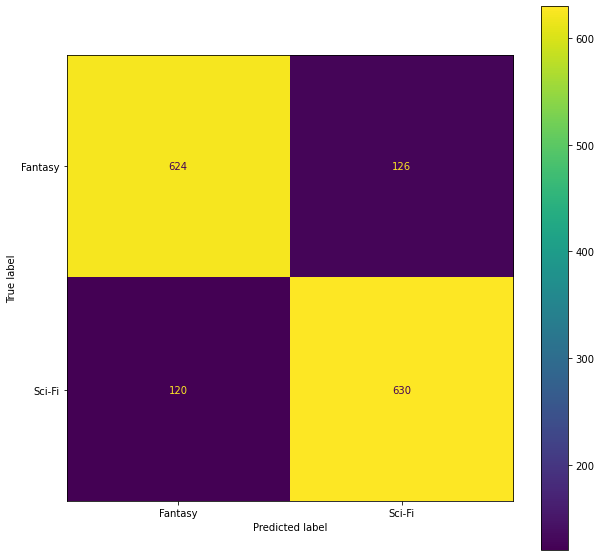

In [16]:
#Confusion Matrix
cm = confusion_matrix(y_test,mvp_preds)
tn,fp,fn,tp = cm.ravel()

labels = ['Fantasy','Sci-Fi']

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
cmp.plot(ax=ax);
plt.show();

 Our next step is to hypertune our parameters to product a better model.

In [25]:
pipe_params = {
    'tfidf__max_features':[3_000], #Capping features at 3,000 per earlier Grid Search Results
    'tfidf__min_df':[2], #Capping at 2 per earlier Grid Search Results
    'tfidf__max_df':[0.13,0.14,0.15], #Set at 0.14 per Grid Search Results
    'tfidf__stop_words' :[None,'english'], #Setting to English per Grid Search Results
    'lr__penalty':['l2','l1','none'],
    'lr__solver':['lbfgs','liblinear'],
    'lr__warm_start':[False,True],
    'lr__verbose':[0,1,2],
    'lr__max_iter':[200,250]
}

In [26]:
mvp_gs = GridSearchCV(mvp_pipe, param_grid=pipe_params,cv=5)

In [27]:
%%time
mvp_gs.fit(X_train,y_train)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penal

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concu

[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\model_s

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [24]:
print(f'The Train Score: {mvp_gs.score(X_train,y_train)}')
print(f'The Test Score: {mvp_gs.score(X_test,y_test)}')
print(f'Best Parameters: {mvp_gs.best_params_}')

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

### Final Product

In [ ]:
#Instantiating Final Product Pipeline
fp_pipe = Pipeline([
    ('cvec',CountVectorizer(max_features=4_000,min_df=2)),
    ('lr',LogisticRegression(max_iter=200))
])

In [ ]:
#Fitting Final Product Model
fp_pipe.fit(X_train,y_train)

In [ ]:
#Scoring Final Product Model
print(f'Train Score:{fp_pipe.score(X_train,y_train)}')
print(f'Test Score:{fp_pipe.score(X_test,y_test)}')

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test,fp_pipe.predict(X_test))
tn,fp,fn,tp = cm.ravel()

labels = ['Fantasy','Sci-Fi']

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
cmp.plot(ax=ax);
plt.show();

Our gridsearch improved our model's ability to accurately classify Sci-Fi posts!

## Boosting Models to the Extreme

In [ ]:
#Boosting Imports
from xgboost import XGBClassifier

In [ ]:
#Prints a cross val score
def print_cross_val(model):
    print(f'The Train Score: {cross_val_score(model,X_train,y_train).mean()}')
    print(f'The Test Score: {cross_val_score(model,X_test,y_test).mean()}')

In [ ]:
#XGB w/ Count Vectorizer Pipeline
cv_xgb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb_pipe', XGBClassifier(objective='binary:logistic'))
])

In [ ]:
#Fitting model
cv_xgb_pipe.fit(X_train,y_train)

In [ ]:
#XGB w/ TF-IDF Vectorizer Pipeline
tf_xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb_pipe', XGBClassifier())
])

In [ ]:
#Fitting model
tf_xgb_pipe.fit(X_train,y_train)

## Tuned Support Vector Machine with TF-IDF Vectorizer

In [ ]:
tuned_tf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc',SVC())
])

## Word Frequency Analysis

In [ ]:
#Pipeline Parameters
pipe_params = {
    'tfidf__max_features':[3_000], #Capping features at 3,000 per earlier Grid Search Results
    'tfidf__min_df':[2], #Capping at 2 per earlier Grid Search Results
    'tfidf__max_df':[0.11,0.12,0.13,0.14,0.15,.2,.35,.4,.5], #Set at 0.14 per Grid Search Results
    'tfidf__stop_words' :[None,'english'] #Setting to English per Grid Search Results
    
}

In [ ]:
pass2_gs = GridSearchCV(tf_nb_pipe, param_grid=pipe_params,cv=5)

In [ ]:
#Reading in data, droping unnecessary column from export
mvp_df = pd.read_csv('./data/mvp.csv')
mvp_df.drop(columns=['Unnamed: 0'],inplace=True)

#Train Test Split
X = mvp_df['title']
y = mvp_df['subreddit']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

In [ ]:
%%time
pass2_gs.fit(X_train,y_train)

In [ ]:
pass2_gs.best_params_

In [ ]:
pass2_gs.best_score_

In [ ]:
preds_pass2 = pass2_gs.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test,preds_pass2)
tn,fp,fn,tp = cm.ravel()

labels = ['Fantasy','Sci-Fi']

cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
cmp.plot(ax=ax);
plt.show();

## Examining Word Count

In [ ]:
tvec = TfidfVectorizer(max_df=0.14,max_features=3000,min_df=2,stop_words='english')

In [ ]:
title_words = pd.DataFrame(
    tvec.fit_transform(X_train).todense(),
    columns = tvec.get_feature_names())

In [ ]:
title_words.sum().sort_values(ascending=False).head(10).plot(kind='barh');

### TO-DO
Statistic descriptions of the words!